In [1]:
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from pathFunc import dbPath

In [2]:
#conn = sqlite3.connect('c:\\Users\\shash\\OneDrive - TU Eindhoven\\Shashank Prabhu University\\Year 2\\Year 2 Q4\\Data Challenge 2\\Git DC2\\data\\database_final (1).db')
conn = sqlite3.connect(dbPath())
query_burg = """SELECT * FROM table_name
WHERE "Crime Type" = "Burglary"
"""
query_sun = """SELECT * FROM sunlight"""
query_house = """SELECT * FROM housing_by_lsoa"""
query_unep = """SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"""

df_burglary_all = pd.read_sql(query_burg, conn)
df_sunlight = pd.read_sql(query_sun, conn)
df_housing = pd.read_sql(query_house, conn)
df_unemployment_all = pd.read_sql(query_unep, conn)
#getting data from dataabse and storing in DF
conn.close()

In [3]:
df_unemployment = df_unemployment_all.rename(columns={'geogcode': 'LSOA code'}) 
df_unemployment['Month'] =  pd.to_datetime(df_unemployment['date'])
df_unemployment_5yr = df_unemployment[(df_unemployment['Month'].dt.year >= 2013) & (df_unemployment['Month'].dt.year <= 2019)]
df_unemployment_5yr = df_unemployment_5yr[df_unemployment_5yr['LSOA code'] != 'Column Total']
df_unemployment_5yr["Unemployment"] = df_unemployment_5yr["value"]
df_unemployment_5yr = df_unemployment_5yr.drop(columns=["date", "index", "value"], axis=1)
#filterig unemployment to 5 year time spand of 2014 to 2019 and renaming columns for compatibility 
#2013 included for time lag

In [4]:
df_burglary = df_burglary_all.drop(columns=['Reported by', 'Falls within']).dropna()
df_bar=df_burglary[df_burglary['LSOA name'].str.contains('Barnet')]
df_bar['Month'] = pd.to_datetime(df_bar['Month'])
df_bar['Year']= df_bar['Month'].dt.year
df_bar_5yr = df_bar[(df_bar['Month'].dt.year >= 2013) & (df_bar['Month'].dt.year <= 2019)]
#Filtering for Barnet data, 2013 included for time lag

C:\Users\shash\AppData\Local\Temp\ipykernel_30888\3804163310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar['Month'] = pd.to_datetime(df_bar['Month'])
C:\Users\shash\AppData\Local\Temp\ipykernel_30888\3804163310.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar['Year']= df_bar['Month'].dt.year


In [5]:
df_sunlight['Month'] = pd.to_datetime(df_sunlight['Year-Month'])
df_sunlight=df_sunlight.drop(columns=["Year-Month", "index"], axis=1)
#Sunlight DF, ensuring compatibility by creating Datime Col


In [6]:
#df_housing = df_housing.drop(columns=["index"], axis=1)
#Housing dataframe
df_housing
df_housing_clean = df_housing[["Proportion of indep", "Proportion small house", "Proportion social", "Proportion rented", "LSOA name",  "LSOA code" ]]

In [7]:
burglaries_per_lsoa_month = df_bar_5yr[df_bar_5yr['Crime type'] == 'Burglary'].groupby(['LSOA code', 'Month']).size()
burglaries_per_lsoa_month = burglaries_per_lsoa_month.reset_index(name='Total Burglaries')
#Getting total burglaries per LSOA on a Monthly basis

In [8]:
temp_merged = burglaries_per_lsoa_month.merge(df_housing_clean, how='left', on=['LSOA code']).dropna() #Merging Berg and Housing
df_merged = temp_merged.merge(df_sunlight, how='left', on=['Month']) #Merging sunlight and (Housing+Burg)
df_merged_2 =  df_merged.merge(df_unemployment_5yr, how='left', on=['Month', 'LSOA code']) #Mergving pervious with unemployment
temp_merged_clean = df_merged_2.drop(columns=['LSOA name']) #Drop unnecessary Cols

In [9]:
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Giving Lag value in months
df = temp_merged_clean

for lag in lags:
    column_name_unep = f"Unemployment_PctChange_{lag}m"  # New column name for unemployment
    df[column_name_unep] = df.groupby('LSOA code')['Unemployment'].pct_change(periods=lag) * 100
    df[column_name_unep].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

    column_name_burg = f"Total_Burglaries_PctChange_{lag}m"  # New column name for burglaries
    df[column_name_burg] = df.groupby('LSOA code')['Total Burglaries'].pct_change(periods=lag) * 100
    df[column_name_burg].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

df.fillna(0, inplace=True)  # Replace remaining NaN values with zeros


In [10]:
# Create dummy variables for the 'LSOA code' column
dummy_df = pd.get_dummies(temp_merged_clean['LSOA code'], prefix='LSOA')

# Concatenate the dummy variables with the original DF
df_temp_merged_clean_dummies = pd.concat([temp_merged_clean, dummy_df], axis=1)
df_temp_merged_clean_dummies['Month_Int'] = df_temp_merged_clean_dummies['Month'].dt.month #Creating month int col
df_temp_merged_clean_dummies.head()

# Create dummy variables for the 'Month_Int' column
month_dummies = pd.get_dummies(df_temp_merged_clean_dummies['Month_Int'], prefix='Month')

# Concatenate the dummy variables with the original DataFrame
df_temp_merged_clean_dummies = pd.concat([df_temp_merged_clean_dummies, month_dummies], axis=1)
#df_temp_merged_clean_dummies.head()


In [11]:
df_temp_merged_clean_train = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year >= 2014) & (df_temp_merged_clean_dummies['Month'].dt.year <= 2018)]
df_temp_merged_clean_test = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year == 2019)] 
#Filtering test and train based on time span of 2014 to 2018 for Train and 2019 for Test

In [12]:
lags_unep_burg = ["Unemployment_PctChange_1m", "Unemployment_PctChange_2m", "Unemployment_PctChange_3m", "Unemployment_PctChange_4m", "Unemployment_PctChange_5m", "Unemployment_PctChange_6m", "Unemployment_PctChange_7m", "Unemployment_PctChange_8m", "Unemployment_PctChange_9m", "Unemployment_PctChange_10m", "Unemployment_PctChange_11m", "Unemployment_PctChange_12m", "Total_Burglaries_PctChange_1m", "Total_Burglaries_PctChange_2m", "Total_Burglaries_PctChange_3m", "Total_Burglaries_PctChange_4m", "Total_Burglaries_PctChange_5m", "Total_Burglaries_PctChange_6m", "Total_Burglaries_PctChange_7m", "Total_Burglaries_PctChange_8m", "Total_Burglaries_PctChange_9m", "Total_Burglaries_PctChange_10m", "Total_Burglaries_PctChange_11m", "Total_Burglaries_PctChange_12m"]

X_train = df_temp_merged_clean_train.drop(columns=["Total Burglaries", "LSOA code", "Month_Int", "Month"]) # What you give to the model
y_train = df_temp_merged_clean_train["Total Burglaries"] # What needs to be predicted

X_test = df_temp_merged_clean_test.drop(columns=["Total Burglaries", "LSOA code", "Month_Int", "Month"]) # What you give to the model
y_test = df_temp_merged_clean_test["Total Burglaries"] # What needs to be predicted


In [13]:
X_train.head()

,Proportion of indep,Proportion small house,Proportion social,Proportion rented,Sunlight,Unemployment,Unemployment_PctChange_1m,Total_Burglaries_PctChange_1m,Unemployment_PctChange_2m,Total_Burglaries_PctChange_2m,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
6,0.969072,0.021277,0.0,0.09375,3.348560,10.0,0.0,-50.0,0.0,-50.0,...,0,0,0,0,0,0,0,0,0,0
7,0.969072,0.021277,0.0,0.09375,4.691432,10.0,0.0,0.0,0.0,-50.0,...,1,0,0,0,0,0,0,0,0,0
8,0.969072,0.021277,0.0,0.09375,5.253036,10.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
9,0.969072,0.021277,0.0,0.09375,7.468832,10.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
10,0.969072,0.021277,0.0,0.09375,4.597112,15.0,50.0,0.0,50.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [14]:
model = XGBRegressor()
model.fit(X_train, y_train)
#Fitting data to model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

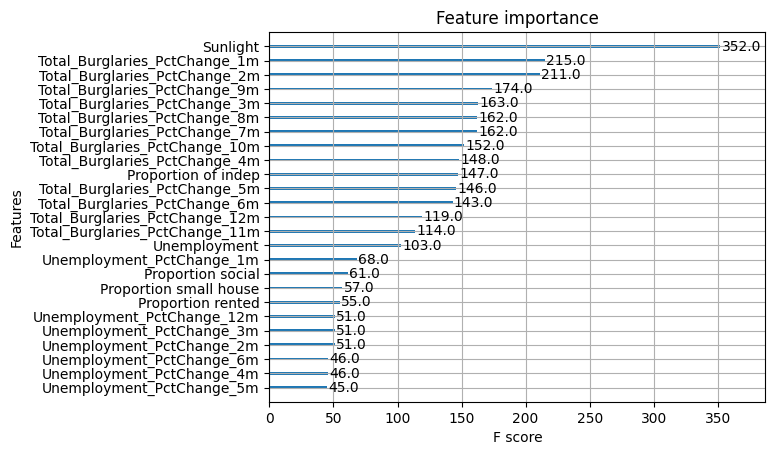

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
xgb.plot_importance(model, ax=plt.gca(), max_num_features=25)
#Plotting the most important featurs

In [16]:
pred_train = model.predict(X_train)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
predictions = model.predict(X_test)

In [17]:
# Calculate the train performance metrics
mse_train = mean_squared_error(y_train, pred_train)
mae_train = mean_absolute_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)
medae_train = median_absolute_error(y_train, pred_train)

# Calculate the test performance metrics
mse_test = mean_squared_error(y_test, predictions)
mae_test = mean_absolute_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)
medae_test = median_absolute_error(y_test, predictions)

# Create a dictionary with the train and test metric names and values
metrics = {
    'Metric': ['MSE', 'MAE', 'R^2', "MedAE"],
    'Train Value': [mse_train, mae_train, r2_train, medae_train],
    'Test Value': [mse_test, mae_test, r2_test, medae_test]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Train Value,Test Value
0,MSE,0.001805,0.073974
1,MAE,0.024363,0.079351
2,R^2,0.999026,0.956436
3,MedAE,0.011813,0.017450
